### The following program solves the stochastic growth model with simulations PEA. It uses a non-linear least squares routine to minimize the sum of squared errors.


#### Translated from Eva Carceles-Poveda's (2003) MATLAB codes

In [1]:
# Importing packages
import numpy as np

import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The nlls (Non-linear least squares) function is copied below

In [2]:
def nlls(DEP,IND1,IND2,T,IBETA):
    
    GBETA = np.zeros((3,1))

    HALT = 0

    DER1 = np.zeros((T-1,1))
    DER2 = np.zeros((T-1,1))
    DER3 = np.zeros((T-1,1))
    F = np.zeros((T-1,1))

    MAX_IT = 100
    smooth = 0.6
    prec = 0.001

    it = 0

    while (HALT == 0 and it < MAX_IT):

        # TAYLOR AROUND IBETA

        IBETA = (smooth*IBETA) + (1-smooth)*GBETA


        DER1 = np.exp(IBETA[0]*np.ones((T-1,1))+(IBETA[1]*IND1)+(IBETA[2]*IND2))
        F = DER1.copy()
        DER2 = F * IND1
        DER3 = F * IND2

        DER = np.concatenate((DER1,DER2,DER3), axis=1)

        # 1.1 Estimate coefficients of linearized equation
        #################################################################
        # DEP - F + DER(Tx3)*IBETA(3x1) = DER(Tx3)*GBETA(3x1) + Error   #
        #################################################################

        Y = DEP - F + np.matmul(DER,IBETA)

        GBETA = np.linalg.inv(DER.T@DER)@DER.T@Y;
        diffnlls = np.matmul(np.ones((1,3)),np.abs(GBETA-IBETA))

        if diffnlls < prec:
            HALT = 1

        it = it + 1

    return GBETA

#### The Hodrick-Prescott filter function is copied below

In [3]:
def hp1(y,w):

    """ Syntax: yhp, ytr = hp1(y, w)
    
    This function computes the filtered series of y, using
    a smoothing parameter w. 
    
    The code is from I. Izvorski.
    """

    t, s = y.shape
    
    if t < s:
        y = y.T

    a = 6*w + 1
    b = -4*w
    c = w
    d = np.array([[c,b,a]])
    d = np.ones((t,1))*d
    m = np.diag(d[:,2])+np.diag(d[0:-1,1],1)+np.diag(d[0:-1,1],-1)
    m = m+np.diag(d[0:-2,0],2)+np.diag(d[0:-2,0],-2)

    m[0,0] = 1+w;       m[0,1] = -2*w;
    m[1,0] = -2*w;      m[1,1] = 5*w+1;
    m[-2,-2] = 5*w+1;   m[-2,-1] = -2*w;
    m[-1,-2] = -2*w;    m[-1,-1] = 1+w;
    
    ytr = np.matmul(np.linalg.inv(m),y)
    yhp = y-ytr

    return yhp, ytr

In [4]:
# Parameters
bet = 0.99
alf = 0.36
delta = 0.025
T = 10000
sig = 1
rhoz = 0.95
sigepsz = 0.01
lam = 0

In [5]:
# load shocks

# from numpy (.npy) file
with open('zz.npy', 'rb') as f:
    z = np.load(f)

# or from text (.txt) file
#with open('zz.txt', 'rb') as f:
#    z = np.loadtxt(f)


In [6]:
# Steady state
zs = 1
ks = ((1-bet*(1-delta))/(bet*alf))**(1/(alf-1))
ys = zs*(ks**alf)
ins = delta*ks
cs = ys-ins

print('Steady State:', ks, ys, cs, ins)

Steady State: 37.98925353815227 3.70405881159033 2.7543274731365233 0.9497313384538068


In [7]:
# Initial parameters for the PEA functions
bita = np.zeros((3,1))
#with open('bita.npy', 'rb') as f:
#    bita = np.load(f)
bita0 = np.ones((3,1))
bita = (bita-lam)/(1-lam)

# Define matrices
x = np.zeros((T+1,1))
c = np.zeros((T+1,1))
k = np.zeros((T+1,1))
inv = np.zeros((T+1,1))
Pea = np.zeros((T+1,1))

etol = 1e-03
it = 0

while np.abs(bita-bita0).max() > etol:
    it = it+1
    bita = lam*bita0+(1-lam)*bita
    bita0 = bita.copy()
    
    # Simulation for given parameters and no asset constraints

    k[0]=ks
    c[0]=cs
    inv[0]=ins

    for i in np.arange(1,T+1):
        Pea[i]=np.exp(bita[0]+bita[1]*np.log(z[i])+bita[2]*np.log(k[i-1]))
        c[i]=(bet*Pea[i])**(-1/sig)
        inv[i]=z[i]*(k[i-1]**alf)-c[i]
        k[i]=inv[i]+(1-delta)*k[i-1]
    
    E3=((c[2:T+1]**(-sig))*(alf*z[2:T+1][:,np.newaxis]*(k[1:T]**(alf-1))+(1-delta)))
    
    # calculating the minimizing parameters
    bita = nlls(E3,np.log(z[1:T])[:,np.newaxis],np.log(k[0:T-1]),T,bita0)
    eva = np.array([np.mean(k), np.mean(c), np.mean(inv)])
    print("Means:", eva)
    print("iteration = ", it, ", error = ", np.abs(bita-bita0).max(), sep='')
    #with open('bita.npy', 'wb') as f:
    #    np.save(f, bita)
    

Means: [249.985    1.0103   6.2701]
iteration = 1, error = 0.030397001465967882
Means: [248.266    1.0354   6.2269]
iteration = 2, error = 0.029522168010966174
Means: [246.507    1.061    6.1828]
iteration = 3, error = 0.028664849651170596
Means: [244.7076   1.0871   6.1376]
iteration = 4, error = 0.027826468129757753
Means: [242.867    1.1137   6.0914]
iteration = 5, error = 0.02700588961123271
Means: [240.985    1.1408   6.0442]
iteration = 6, error = 0.026203831950953937
Means: [239.061    1.1684   5.9959]
iteration = 7, error = 0.025421071235769283
Means: [237.0946   1.1965   5.9465]
iteration = 8, error = 0.02465653105068777
Means: [235.0854   1.2251   5.8961]
iteration = 9, error = 0.02391088410277678
Means: [233.0332   1.2542   5.8446]
iteration = 10, error = 0.023184232271328792
Means: [230.9375   1.2838   5.792 ]
iteration = 11, error = 0.02247666677892607
Means: [228.7981   1.3139   5.7383]
iteration = 12, error = 0.021788848593210508
Means: [226.615    1.3444   5.6835]
itera

Means: [44.4272  2.8003  1.1112]
iteration = 105, error = 0.0032362814467318535
Means: [44.1208  2.7983  1.1035]
iteration = 106, error = 0.0031173123682737836
Means: [43.8292  2.7963  1.0962]
iteration = 107, error = 0.0030001661196574214
Means: [43.5516  2.7944  1.0892]
iteration = 108, error = 0.002885057455362716
Means: [43.2874  2.7925  1.0826]
iteration = 109, error = 0.0027721771607207013
Means: [43.0358  2.7907  1.0763]
iteration = 110, error = 0.0026616926545746655
Means: [42.7962  2.789   1.0703]
iteration = 111, error = 0.002553748784351495
Means: [42.5681  2.7873  1.0646]
iteration = 112, error = 0.0024484686662224198
Means: [42.3508  2.7857  1.0591]
iteration = 113, error = 0.0023459547259996327
Means: [42.1439  2.7841  1.0539]
iteration = 114, error = 0.002246289841611321
Means: [41.9468  2.7826  1.049 ]
iteration = 115, error = 0.0021495384387404393
Means: [41.759   2.7811  1.0443]
iteration = 116, error = 0.00205574778647577
Means: [41.58    2.7797  1.0398]
iteration = 

In [8]:
print(bita)

[[ 1.2613]
 [-0.2737]
 [-0.6162]]


 
Enter number of periods for IRFs: 500
You entered: 500


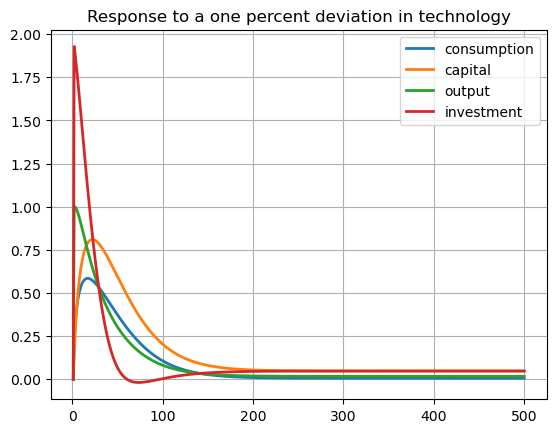

In [9]:
###########################
# Make impulse responses
###########################
print(' ')
while True:
    try:
        NS = int(input('Enter number of periods for IRFs: '))
    except ValueError:
        print("Please enter a valid integer")
        continue
    else:
        if NS < 2:
            print("Please enter a positive integer greater than 1")
            continue
        else:
            print(f'You entered: {NS}')
            break

NS             = NS+1
eps            = np.zeros((NS,1))
eps[1]         = 1
shock          = np.zeros((NS,1))
shock[0]       = 1
Pea            = np.zeros((NS,1))

c              = np.zeros((NS,1)); c[0] = cs
k              = np.zeros((NS,1)); k[0] = ks
y              = np.zeros((NS,1)); y[0] = ys
inv            = np.zeros((NS,1)); inv[0] = ins

for i in np.arange(1,NS):
    shock[i] = np.exp(rhoz*np.log(shock[i-1])+eps[i])
    Pea[i] = np.exp(bita[0]+bita[1]*np.log(shock[i])+bita[2]*np.log(k[i-1]))
    c[i] = (bet*Pea[i])**(-1/sig)
    y[i] = shock[i]*(k[i-1]**alf)
    inv[i] = shock[i]*(k[i-1]**alf)-c[i]
    k[i] = inv[i]+(1-delta)*k[i-1]

# Deviations from steady state
c              = np.log(c/cs)
k              = np.log(k/ks)
y              = np.log(y/ys)
inv            = np.log(inv/ins)


LOG_DEV = np.concatenate((c,k,y,inv), axis=1)

# Plots the Impulse Response Functions
fig, han = plt.subplots()
han.plot(np.arange(1,NS), LOG_DEV[0:NS-1], label=['consumption', 'capital', 'output', 'investment'], linewidth = 2)

han.set(title='Response to a one percent deviation in technology')
han.grid()
han.legend()

fig.savefig("growth_PEA_IRF.jpg", dpi=800)
plt.show()

In [10]:
# Calculate the statistics

while True:
    try:
        NR = int(input('Enter number of periods to simulate for statistics: '))
    except ValueError:
        print("Please enter a valid integer")
        continue
    else:
        if NR < 2:
            print("Please enter a positive integer greater than 1")
            continue
        else:
            print(f'You entered: {NR}')
            break

print(' ')

NR = NR+1

#sd = np.zeros((1,4))
#rd = np.zeros((1,4))

shock          = np.zeros((NR,1))
shock[0]       = 1
Pea            = np.zeros((NR,1))

c           = np.zeros((NR,1)); c[0] = cs
k           = np.zeros((NR,1)); k[0] = ks
y           = np.zeros((NR,1)); y[0] = ys
inv         = np.zeros((NR,1)); inv[0] = ins

#np.random.seed(1337)

for i in np.arange(1,NR):
    shock[i] = np.exp(rhoz*np.log(shock[i-1])+sigepsz*np.random.randn())
    Pea[i] = np.exp(bita[0]+bita[1]*np.log(shock[i])+bita[2]*np.log(k[i-1]))
    c[i] = (bet*Pea[i])**(-1/sig)
    y[i] = shock[i]*(k[i-1]**alf)
    inv[i] = shock[i]*(k[i-1]**alf)-c[i]
    k[i] = inv[i]+(1-delta)*k[i-1]


c           = np.log(c/cs)
k           = np.log(k/ks)
y           = np.log(y/ys)
inv         = np.log(inv/ins)

c       = hp1(c,1600)[0]
k       = hp1(k,1600)[0]
y       = hp1(y,1600)[0]
inv     = hp1(inv,1600)[0]

sd    = np.std(np.concatenate((c[1:NR],k[1:NR],y[1:NR],inv[1:NR]), axis=1),axis=0,ddof=1)
rd    = sd/sd[2]
print('  ')
print(' The average standard deviations for the three variables are:')
print('    c      k      y      in                                  ')
print(sd)
print('  ')
print(' The relative standard deviations for the three variables are:')
print('    c      k      y      in                                  ')
print(rd)

Enter number of periods to simulate for statistics: 500
You entered: 500
 
  
 The average standard deviations for the three variables are:
    c      k      y      in                                  
[0.0043 0.0035 0.0135 0.0412]
  
 The relative standard deviations for the three variables are:
    c      k      y      in                                  
[0.3153 0.26   1.     3.0424]


In [11]:
#!jupyter nbconvert --to script growth_PEA.ipynb